# Objectives
* Identify and visualize regions best suited for specific crops based on weather history, soil texture, and land conditions
* Create predictive models to estimate crop suitability using long-term weather patterns and degradation indicators
* Deploy a web app and chatbot that gives planting recommendations suited to a user's location


## About this project:
This project helps farmers and planners in Kenya decide which crops to grow and where to plant them. It uses satellite images and soil data from the Kenya Space Agency to find the best areas for farming. The tool looks at things like how healthy the land is (using NDVI), what kind of soil is there, and weather history to give smart recommendations.

## Impact
our model assists farmers and decision-makers with key information, making agricultural planning more resilient to climate shifts,soil and weather history.


#### EDA:

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import geopandas as gpd
import fiona
import rasterio
from rasterio.plot import show, show_hist
from shapely.geometry import Point
import matplotlib.pyplot as plt
%matplotlib inline



# Loading geospacial data


In [2]:
temperature = pd.read_csv("geological_data/Temperature at 2 Meters.csv")
temperature['Mean temp'] = temperature.loc[:, 'JAN':'DEC'].mean(axis=1).round(2) # creating a new column of mean data fro JAN to DEC
temperature.head()

,PARAMETER,YEAR,LAT,LON,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANN,Mean temp
0,T2M,2000,-0.5,33.750,25.78,25.78,25.38,25.16,24.97,24.03,23.77,23.81,24.83,24.07,23.67,24.42,24.64,24.64
1,T2M,2000,-0.5,34.375,25.47,26.00,25.88,25.25,24.98,24.32,23.70,23.81,24.64,23.95,23.38,23.32,24.55,24.56
2,T2M,2000,-0.5,35.000,22.27,23.08,23.30,22.20,21.69,20.57,19.77,20.22,20.98,21.17,20.69,20.35,21.35,21.36
3,T2M,2000,-0.5,35.625,16.31,16.87,17.85,16.67,16.10,14.53,13.67,13.92,14.82,15.54,15.43,15.53,15.60,15.60
4,T2M,2000,-0.5,36.250,16.61,17.30,18.35,17.05,16.40,14.83,14.02,14.03,15.12,15.88,15.89,16.53,16.00,16.00


In [3]:
precipitation = pd.read_csv("geological_data/precipitation average.csv")
precipitation['Mean precipitation'] = precipitation.loc[:, 'JAN':'DEC'].mean(axis=1).round(2)# creating a new column of mean data fro JAN to DEC
precipitation.head()

,PARAMETER,YEAR,LAT,LON,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANN,Mean precipitation
0,PRECTOTCORR,2000,-0.5,33.750,1.13,2.06,2.72,5.89,4.43,1.57,2.20,3.88,4.42,5.99,6.88,6.28,3.96,3.95
1,PRECTOTCORR,2000,-0.5,34.375,0.71,1.84,2.26,4.04,2.91,1.38,1.70,2.69,3.31,5.87,5.48,6.72,3.25,3.24
2,PRECTOTCORR,2000,-0.5,35.000,0.62,1.47,2.17,3.31,2.45,1.41,1.93,2.52,2.88,4.96,5.64,5.19,2.88,2.88
3,PRECTOTCORR,2000,-0.5,35.625,0.33,0.65,1.36,2.90,1.74,1.45,2.45,3.29,2.55,3.26,4.95,2.52,2.29,2.29
4,PRECTOTCORR,2000,-0.5,36.250,0.30,0.30,0.88,2.47,1.39,1.42,2.45,3.45,2.15,2.10,3.74,1.86,1.88,1.88


In [4]:
Soil_Wetness = pd.read_csv("geological_data\oot Zone Soil Wetness (surface to 100 cm below).csv")
Soil_Wetness['Mean soil wetness'] = Soil_Wetness.loc[:, 'JAN':'DEC'].mean(axis=1).round(2)# creating a new column of mean data fro JAN to DEC
Soil_Wetness.head()

<>:1: SyntaxWarning: invalid escape sequence '\o'
<>:1: SyntaxWarning: invalid escape sequence '\o'
C:\Users\ericg\AppData\Local\Temp\ipykernel_24444\3856715896.py:1: SyntaxWarning: invalid escape sequence '\o'
  Soil_Wetness = pd.read_csv("geological_data\oot Zone Soil Wetness (surface to 100 cm below).csv")


,PARAMETER,YEAR,LAT,LON,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANN,Mean soil wetness
0,GWETROOT,2000,-0.5,34.375,0.56,0.52,0.52,0.56,0.57,0.54,0.53,0.54,0.54,0.61,0.69,0.77,0.58,0.58
1,GWETROOT,2000,-0.5,35.000,0.51,0.48,0.49,0.51,0.51,0.49,0.49,0.50,0.51,0.54,0.60,0.65,0.52,0.52
2,GWETROOT,2000,-0.5,35.625,0.43,0.41,0.41,0.43,0.43,0.42,0.43,0.45,0.45,0.45,0.48,0.47,0.44,0.44
3,GWETROOT,2000,-0.5,36.250,0.38,0.37,0.36,0.39,0.38,0.38,0.39,0.41,0.41,0.40,0.42,0.40,0.39,0.39
4,GWETROOT,2000,-0.5,36.875,0.40,0.37,0.36,0.39,0.38,0.37,0.38,0.39,0.39,0.38,0.41,0.41,0.39,0.39


### Transforming long lat into geodataframe

In [5]:
# Create geometry column from LON and LAT
geometry = [Point(xy) for xy in zip(precipitation['LON'], precipitation['LAT'])]

# Create GeoDataFrame
gdf_precipitation = gpd.GeoDataFrame(precipitation, geometry=geometry)

# Set coordinate system (WGS84 for lat/lon)
gdf_precipitation.set_crs(epsg=4326, inplace=True)
gdf_precipitation.head()

,PARAMETER,YEAR,LAT,LON,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANN,Mean precipitation,geometry
0,PRECTOTCORR,2000,-0.5,33.750,1.13,2.06,2.72,5.89,4.43,1.57,2.20,3.88,4.42,5.99,6.88,6.28,3.96,3.95,POINT (33.75000 -0.50000)
1,PRECTOTCORR,2000,-0.5,34.375,0.71,1.84,2.26,4.04,2.91,1.38,1.70,2.69,3.31,5.87,5.48,6.72,3.25,3.24,POINT (34.37500 -0.50000)
2,PRECTOTCORR,2000,-0.5,35.000,0.62,1.47,2.17,3.31,2.45,1.41,1.93,2.52,2.88,4.96,5.64,5.19,2.88,2.88,POINT (35.00000 -0.50000)
3,PRECTOTCORR,2000,-0.5,35.625,0.33,0.65,1.36,2.90,1.74,1.45,2.45,3.29,2.55,3.26,4.95,2.52,2.29,2.29,POINT (35.62500 -0.50000)
4,PRECTOTCORR,2000,-0.5,36.250,0.30,0.30,0.88,2.47,1.39,1.42,2.45,3.45,2.15,2.10,3.74,1.86,1.88,1.88,POINT (36.25000 -0.50000)


In [6]:
# Create geometry column from LON and LAT
geometry = [Point(xy) for xy in zip(temperature['LON'], temperature['LAT'])]

# Create GeoDataFrame
gdf_temperature = gpd.GeoDataFrame(temperature, geometry=geometry)

# Set coordinate system (WGS84 for lat/lon)
gdf_temperature.set_crs(epsg=4326, inplace=True)
gdf_temperature.head()

,PARAMETER,YEAR,LAT,LON,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANN,Mean temp,geometry
0,T2M,2000,-0.5,33.750,25.78,25.78,25.38,25.16,24.97,24.03,23.77,23.81,24.83,24.07,23.67,24.42,24.64,24.64,POINT (33.75000 -0.50000)
1,T2M,2000,-0.5,34.375,25.47,26.00,25.88,25.25,24.98,24.32,23.70,23.81,24.64,23.95,23.38,23.32,24.55,24.56,POINT (34.37500 -0.50000)
2,T2M,2000,-0.5,35.000,22.27,23.08,23.30,22.20,21.69,20.57,19.77,20.22,20.98,21.17,20.69,20.35,21.35,21.36,POINT (35.00000 -0.50000)
3,T2M,2000,-0.5,35.625,16.31,16.87,17.85,16.67,16.10,14.53,13.67,13.92,14.82,15.54,15.43,15.53,15.60,15.60,POINT (35.62500 -0.50000)
4,T2M,2000,-0.5,36.250,16.61,17.30,18.35,17.05,16.40,14.83,14.02,14.03,15.12,15.88,15.89,16.53,16.00,16.00,POINT (36.25000 -0.50000)


In [7]:
# Create geometry column from LON and LAT
geometry = [Point(xy) for xy in zip(Soil_Wetness['LON'], Soil_Wetness['LAT'])]
# Create GeoDataFrame
gdf_Soil_Wetness = gpd.GeoDataFrame(Soil_Wetness, geometry=geometry)
# Set coordinate system (WGS84 for lat/lon)
gdf_Soil_Wetness.set_crs(epsg=4326, inplace=True)
gdf_Soil_Wetness.head()

,PARAMETER,YEAR,LAT,LON,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANN,Mean soil wetness,geometry
0,GWETROOT,2000,-0.5,34.375,0.56,0.52,0.52,0.56,0.57,0.54,0.53,0.54,0.54,0.61,0.69,0.77,0.58,0.58,POINT (34.37500 -0.50000)
1,GWETROOT,2000,-0.5,35.000,0.51,0.48,0.49,0.51,0.51,0.49,0.49,0.50,0.51,0.54,0.60,0.65,0.52,0.52,POINT (35.00000 -0.50000)
2,GWETROOT,2000,-0.5,35.625,0.43,0.41,0.41,0.43,0.43,0.42,0.43,0.45,0.45,0.45,0.48,0.47,0.44,0.44,POINT (35.62500 -0.50000)
3,GWETROOT,2000,-0.5,36.250,0.38,0.37,0.36,0.39,0.38,0.38,0.39,0.41,0.41,0.40,0.42,0.40,0.39,0.39,POINT (36.25000 -0.50000)
4,GWETROOT,2000,-0.5,36.875,0.40,0.37,0.36,0.39,0.38,0.37,0.38,0.39,0.39,0.38,0.41,0.41,0.39,0.39,POINT (36.87500 -0.50000)


# PROCESSING GEOJSON FILES:


In [8]:
print(fiona.__version__)

1.10.1


In [9]:
rasterio.__version__

'1.4.3'

## Reading files


#### Creating a function to help load data quicker and take up less space

In [10]:
def processing_data(filepath): #allows us to open the data with necesarry information without repetition
    data = rasterio.open(filepath)
    print(data)
    array_data = data.read()
    print(f"""this is an array of the data: 
    {array_data}
    """) #the data is in a numpy array that the library knows how to transform into satelite images
    print(f"""this is the data information on the image 
    {data.meta}
    """)
    num_bands = data.count
    print(f"""the number of bands in this image: {num_bands}""") # this shows the number of bands/layers in the image

    show(data) #displays the image 
    
    
    

In [11]:
#processing_data("ksa_data/Kenya Crop Mask 2019.tiff")

In [12]:
#processing_data("ksa_data/Kenya NDVI 2022.tiff")

In [13]:
#processing_data("ksa_data/Kenya Soil Degradation Data.tiff")

In [14]:
#processing_data("ksa_data/Kenya Soil Texture Types.tiff")

In [15]:
#processing_data("ksa_data/Kenya_CropType_EndOfSeason_LongRains_2021.tiff")

In [16]:
#processing_data("ksa_data/Kenya_CropType_EndOfSeason_LongRains_2023.tiff")

In [17]:
#croptype = processing_data("ksa_data/Kenya_CropType_InSeason_ShortRains_2022-2023.tiff")
#croptype

A DN value in an NDVI raster might correspond to vegetation index levels (e.g. greener = higher DN)

In a crop mask, DN values could represent presence or absence of crops or specific crop types

For soil or degradation maps, different DNs might map to soil classes or condition levels

In [18]:
data = rasterio.open("ksa_data/Kenya_CropType_InSeason_ShortRains_2022-2023.tiff")
data

c:\Users\ericg\anaconda3\Lib\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


<open DatasetReader name='ksa_data/Kenya_CropType_InSeason_ShortRains_2022-2023.tiff' mode='r'>

# shape files 

In [19]:
data = gpd.read_file("KEN/AgroMaps/Africa/shapefiles/KEN/admin1/ken.shp")
data.head()


,UNCODEOR,CNTNAME3,COUNTRY_NA,CNTCODE_,NAME1_,PCODE,COMMENTS_,geometry
0,404.0,KEN,Kenya,114.0,CENTRAL,KEN001,None,"POLYGON ((36.25160 -0.12465, 36.25330 -0.12057..."
1,404.0,KEN,Kenya,114.0,COAST,KEN002,None,"MULTIPOLYGON (((37.69361 -3.16358, 37.78766 -3..."
2,404.0,KEN,Kenya,114.0,EASTERN,KEN003,None,"POLYGON ((36.05642 3.68088, 36.06246 3.74481, ..."
3,404.0,KEN,Kenya,114.0,N. EASTERN,KEN004,None,"POLYGON ((38.68931 0.50363, 38.69806 0.50279, ..."
4,404.0,KEN,Kenya,114.0,NAIROBI,KEN005,None,"POLYGON ((36.67882 -1.30289, 36.68127 -1.29845..."


In [20]:
data.shape

(8, 8)

In [21]:
data2 = gpd.read_file("KEN/AgroMaps/Africa/shapefiles/KEN/admin2/ken.shp")
data2.head()

,UNCODEOR,CNTNAME3,COUNTRY_NA,CNTCODE_,NAME1_,PCODE,NAME2_,DCODE,COMMENTS_,geometry
0,404.0,KEN,Kenya,114.0,CENTRAL,KEN001,KIAMBU,KEN001001,None,"POLYGON ((36.52517 -1.23252, 36.53603 -1.19584..."
1,404.0,KEN,Kenya,114.0,CENTRAL,KEN001,KIRINYAGA,KEN001002,None,"POLYGON ((37.21025 -0.42827, 37.21194 -0.41933..."
2,404.0,KEN,Kenya,114.0,CENTRAL,KEN001,MURANGA,KEN001003,None,"POLYGON ((36.73126 -0.67027, 36.73064 -0.66761..."
3,404.0,KEN,Kenya,114.0,CENTRAL,KEN001,NYANDARUA,KEN001004,None,"POLYGON ((36.25160 -0.12465, 36.25330 -0.12057..."
4,404.0,KEN,Kenya,114.0,CENTRAL,KEN001,NYERI,KEN001005,None,"POLYGON ((36.60928 -0.32549, 36.61883 -0.31163..."


In [22]:
data2.shape

(47, 10)

In [23]:
data3 = gpd.read_file("KEN/AgroMaps/Africa/shapefiles/KEN/admin1/ken.shp")
data3.head()

,UNCODEOR,CNTNAME3,COUNTRY_NA,CNTCODE_,NAME1_,PCODE,COMMENTS_,geometry
0,404.0,KEN,Kenya,114.0,CENTRAL,KEN001,None,"POLYGON ((36.25160 -0.12465, 36.25330 -0.12057..."
1,404.0,KEN,Kenya,114.0,COAST,KEN002,None,"MULTIPOLYGON (((37.69361 -3.16358, 37.78766 -3..."
2,404.0,KEN,Kenya,114.0,EASTERN,KEN003,None,"POLYGON ((36.05642 3.68088, 36.06246 3.74481, ..."
3,404.0,KEN,Kenya,114.0,N. EASTERN,KEN004,None,"POLYGON ((38.68931 0.50363, 38.69806 0.50279, ..."
4,404.0,KEN,Kenya,114.0,NAIROBI,KEN005,None,"POLYGON ((36.67882 -1.30289, 36.68127 -1.29845..."


In [24]:
data3.shape

(8, 8)

In [25]:
data4 = gpd.read_file("KEN/AgroMaps/Africa/shapefiles/KEN/admin2/ken.shp")
data4.head()

,UNCODEOR,CNTNAME3,COUNTRY_NA,CNTCODE_,NAME1_,PCODE,NAME2_,DCODE,COMMENTS_,geometry
0,404.0,KEN,Kenya,114.0,CENTRAL,KEN001,KIAMBU,KEN001001,None,"POLYGON ((36.52517 -1.23252, 36.53603 -1.19584..."
1,404.0,KEN,Kenya,114.0,CENTRAL,KEN001,KIRINYAGA,KEN001002,None,"POLYGON ((37.21025 -0.42827, 37.21194 -0.41933..."
2,404.0,KEN,Kenya,114.0,CENTRAL,KEN001,MURANGA,KEN001003,None,"POLYGON ((36.73126 -0.67027, 36.73064 -0.66761..."
3,404.0,KEN,Kenya,114.0,CENTRAL,KEN001,NYANDARUA,KEN001004,None,"POLYGON ((36.25160 -0.12465, 36.25330 -0.12057..."
4,404.0,KEN,Kenya,114.0,CENTRAL,KEN001,NYERI,KEN001005,None,"POLYGON ((36.60928 -0.32549, 36.61883 -0.31163..."


In [26]:
data4.shape

(47, 10)

In [27]:
data2 == data4
#both datasets are the same hence i am going to select one for the projects

,UNCODEOR,CNTNAME3,COUNTRY_NA,CNTCODE_,NAME1_,PCODE,NAME2_,DCODE,COMMENTS_,geometry
0,True,True,True,True,True,True,True,True,False,True
1,True,True,True,True,True,True,True,True,False,True
2,True,True,True,True,True,True,True,True,False,True
3,True,True,True,True,True,True,True,True,False,True
4,True,True,True,True,True,True,True,True,False,True
5,True,True,True,True,True,True,True,True,False,True
6,True,True,True,True,True,True,True,True,False,True
7,True,True,True,True,True,True,True,True,False,True
8,True,True,True,True,True,True,True,True,False,True
9,True,True,True,True,True,True,True,True,False,True


# Analysis


In [28]:
data2 = gpd.read_file("KEN/AgroMaps/Africa/shapefiles/KEN/admin2/ken.shp")
data2.head()

,UNCODEOR,CNTNAME3,COUNTRY_NA,CNTCODE_,NAME1_,PCODE,NAME2_,DCODE,COMMENTS_,geometry
0,404.0,KEN,Kenya,114.0,CENTRAL,KEN001,KIAMBU,KEN001001,None,"POLYGON ((36.52517 -1.23252, 36.53603 -1.19584..."
1,404.0,KEN,Kenya,114.0,CENTRAL,KEN001,KIRINYAGA,KEN001002,None,"POLYGON ((37.21025 -0.42827, 37.21194 -0.41933..."
2,404.0,KEN,Kenya,114.0,CENTRAL,KEN001,MURANGA,KEN001003,None,"POLYGON ((36.73126 -0.67027, 36.73064 -0.66761..."
3,404.0,KEN,Kenya,114.0,CENTRAL,KEN001,NYANDARUA,KEN001004,None,"POLYGON ((36.25160 -0.12465, 36.25330 -0.12057..."
4,404.0,KEN,Kenya,114.0,CENTRAL,KEN001,NYERI,KEN001005,None,"POLYGON ((36.60928 -0.32549, 36.61883 -0.31163..."


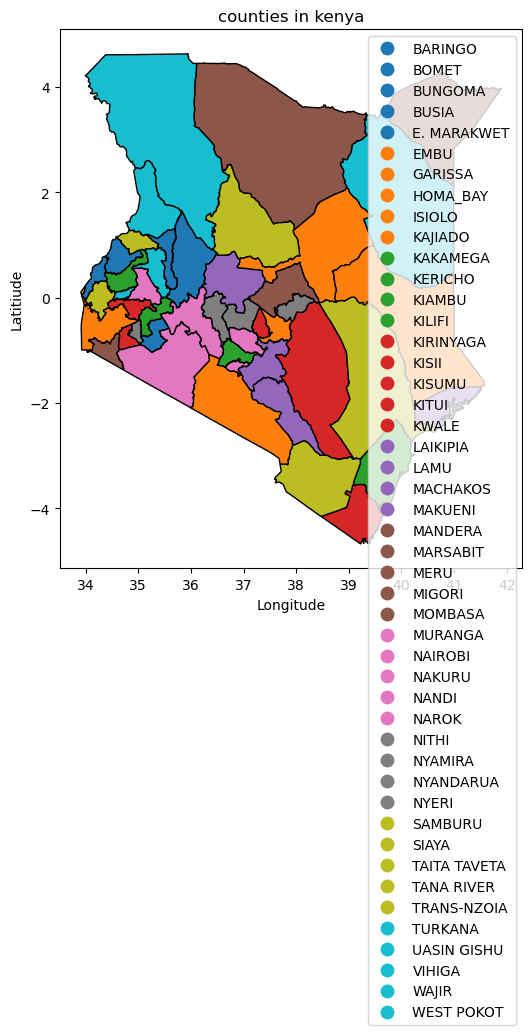

In [29]:
fig, ax = plt.subplots(figsize=(7,7))
data2.plot('NAME2_', legend=True, edgecolor='black',ax=ax)
ax.set_title('counties in kenya')
ax.set_ylabel('Latitiude')
ax.set_xlabel('Longitude')
plt.show()

In [30]:
climate = gpd.read_file("climatezones_shapefile/GYGAClimateZones.shp")
climate.head()

,ID,GYGA_CZ,geometry
0,1,1703,"POLYGON ((-31.59240 83.58921, -31.67573 83.589..."
1,2,1903,"POLYGON ((-32.84232 83.50589, -33.00898 83.505..."
2,3,1603,"POLYGON ((-29.34254 83.50589, -29.75918 83.505..."
3,4,1803,"POLYGON ((-37.84202 83.42256, -38.00867 83.422..."
4,5,1903,"POLYGON ((-37.75869 83.42256, -37.84202 83.422..."


In [31]:
climate.shape

(81746, 3)

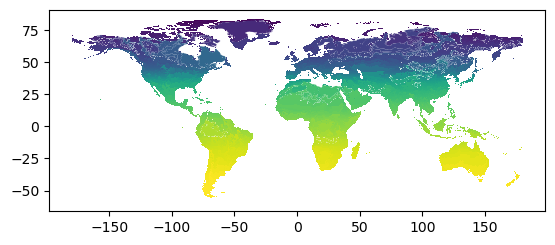

In [32]:
climate.plot('ID')
plt.show()

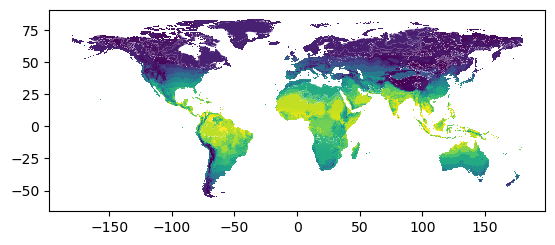

In [33]:
climate.plot('GYGA_CZ')
plt.show()

In [34]:
# confirm both layers use the same coordinate reference system to avoid errors
print(data2.crs) == print(climate.crs)


GEOGCS["GCS_Assumed_Geographic_1 (deprecated)",DATUM["North_American_Datum_1927",SPHEROID["Clarke 1866",6378206.4,294.978698213898,AUTHORITY["EPSG","7008"]],AUTHORITY["EPSG","6267"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["ESRI","104000"]]
EPSG:4326


True

In [35]:
# Convert climate to match data2's CRS
climate = climate.to_crs(data2.crs)


In [36]:
#Spatial Join with climate Polygon to keep kenyan climate
# Spatial join
kenya_data = gpd.sjoin(data2, climate, how="inner", predicate="intersects")
kenya_data.head()

,UNCODEOR,CNTNAME3,COUNTRY_NA,CNTCODE_,NAME1_,PCODE,NAME2_,DCODE,COMMENTS_,geometry,index_right,ID,GYGA_CZ
0,404.0,KEN,Kenya,114.0,CENTRAL,KEN001,KIAMBU,KEN001001,None,"POLYGON ((36.52517 -1.23252, 36.53603 -1.19584...",68163,68164,6201
0,404.0,KEN,Kenya,114.0,CENTRAL,KEN001,KIAMBU,KEN001001,None,"POLYGON ((36.52517 -1.23252, 36.53603 -1.19584...",68342,68343,7201
0,404.0,KEN,Kenya,114.0,CENTRAL,KEN001,KIAMBU,KEN001001,None,"POLYGON ((36.52517 -1.23252, 36.53603 -1.19584...",68004,68005,6401
0,404.0,KEN,Kenya,114.0,CENTRAL,KEN001,KIAMBU,KEN001001,None,"POLYGON ((36.52517 -1.23252, 36.53603 -1.19584...",67972,67973,6301
0,404.0,KEN,Kenya,114.0,CENTRAL,KEN001,KIAMBU,KEN001001,None,"POLYGON ((36.52517 -1.23252, 36.53603 -1.19584...",67932,67933,6501


In [37]:
kenya_data.shape

(1039, 13)

In [38]:
#checking to see if we have data for all the counties
len(kenya_data['NAME2_'].value_counts())

47

In [39]:
kenya_climate = kenya_data[['geometry','ID', 'GYGA_CZ']]
kenya_climate.head()

,geometry,ID,GYGA_CZ
0,"POLYGON ((36.52517 -1.23252, 36.53603 -1.19584...",68164,6201
0,"POLYGON ((36.52517 -1.23252, 36.53603 -1.19584...",68343,7201
0,"POLYGON ((36.52517 -1.23252, 36.53603 -1.19584...",68005,6401
0,"POLYGON ((36.52517 -1.23252, 36.53603 -1.19584...",67973,6301
0,"POLYGON ((36.52517 -1.23252, 36.53603 -1.19584...",67933,6501


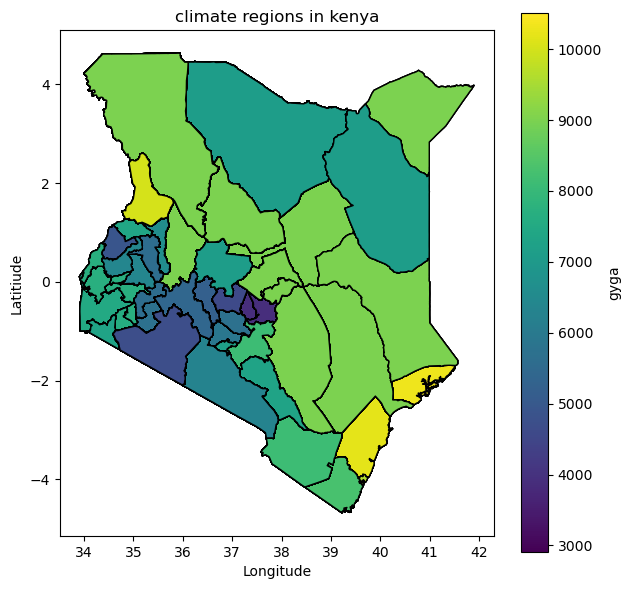

In [40]:
fig, ax = plt.subplots(figsize=(7,7))
kenya_climate.plot('GYGA_CZ', legend=True, edgecolor='black',ax=ax, legend_kwds={'label':'gyga'})
ax.set_title('climate regions in kenya')
ax.set_ylabel('Latitiude')
ax.set_xlabel('Longitude')
plt.show()

### Testing spacial merging  to get information for each county based of mean results


In [57]:
#joining each gdf file to data 2 as to get information on each county to help with lookups and refrencing
temp_with_county = gpd.sjoin(gdf_temperature, data2, how='inner', predicate='intersects')
precip_with_county = gpd.sjoin(gdf_precipitation, data2, how='inner', predicate='intersects')
soil_with_county = gpd.sjoin(gdf_Soil_Wetness, data2, how='inner', predicate='intersects')


C:\Users\ericg\AppData\Local\Temp\ipykernel_24444\1525206640.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: ESRI:104000

  temp_with_county = gpd.sjoin(gdf_temperature, data2, how='inner', predicate='intersects')
C:\Users\ericg\AppData\Local\Temp\ipykernel_24444\1525206640.py:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: ESRI:104000

  precip_with_county = gpd.sjoin(gdf_precipitation, data2, how='inner', predicate='intersects')
C:\Users\ericg\AppData\Local\Temp\ipykernel_24444\1525206640.py:4: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match 

In [ ]:
# groups the data by the county name 
temp_agg = temp_with_county.groupby('NAME2_')['Mean temp'].mean().reset_index()
precip_agg = precip_with_county.groupby('NAME2_')['Mean precipitation'].mean().reset_index()
soil_agg = soil_with_county.groupby('NAME2_')['Mean soil wetness'].mean().reset_index()


In [51]:
#bring them together by county
county_data = temp_agg.merge(precip_agg, on='NAME2_').merge(soil_agg, on='NAME2_')


In [58]:
# the final merged data 
gdf_final = data2.merge(county_data, on='NAME2_')
gdf_final.head()


,UNCODEOR,CNTNAME3,COUNTRY_NA,CNTCODE_,NAME1_,PCODE,NAME2_,DCODE,COMMENTS_,geometry,Mean temp,Mean precipitation,Mean soil wetness
0,404.0,KEN,Kenya,114.0,CENTRAL,KEN001,KIAMBU,KEN001001,None,"POLYGON ((36.52517 -1.23252, 36.53603 -1.19584...",18.897692,2.068462,0.512692
1,404.0,KEN,Kenya,114.0,CENTRAL,KEN001,NYERI,KEN001005,None,"POLYGON ((36.60928 -0.32549, 36.61883 -0.31163...",16.393462,3.421154,0.475385
2,404.0,KEN,Kenya,114.0,COAST,KEN002,KILIFI,KEN002001,None,"MULTIPOLYGON (((39.14636 -3.35020, 39.21850 -3...",26.664038,2.415962,0.532885
3,404.0,KEN,Kenya,114.0,COAST,KEN002,KWALE,KEN002002,None,"MULTIPOLYGON (((38.47149 -4.15677, 38.77943 -4...",26.516538,2.606154,0.480962
4,404.0,KEN,Kenya,114.0,COAST,KEN002,LAMU,KEN002003,None,"MULTIPOLYGON (((40.22508 -2.03483, 40.22837 -2...",27.715385,2.365385,0.518077


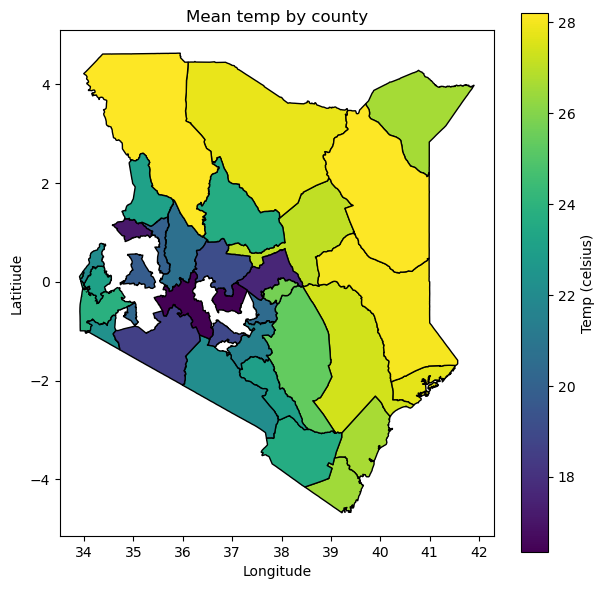

In [60]:

fig, ax = plt.subplots(figsize=(7,7))
gdf_final.plot('Mean temp', legend=True, edgecolor='black',ax=ax, legend_kwds={'label':'Temp (celsius)'})
ax.set_title('Mean temp by county')
ax.set_ylabel('Latitiude')
ax.set_xlabel('Longitude')
plt.show()

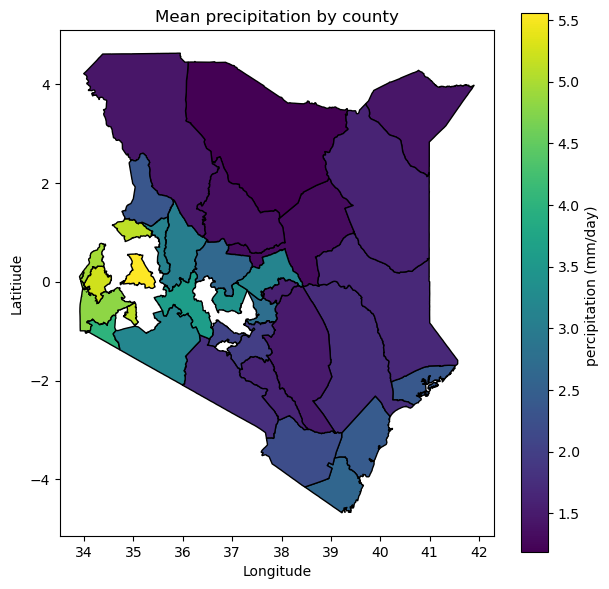

In [65]:

fig, ax = plt.subplots(figsize=(7,7))
gdf_final.plot('Mean precipitation', legend=True, edgecolor='black',ax=ax, legend_kwds={'label':'percipitation (mm/day) '})
ax.set_title('Mean precipitation by county')
ax.set_ylabel('Latitiude')
ax.set_xlabel('Longitude')
plt.show()

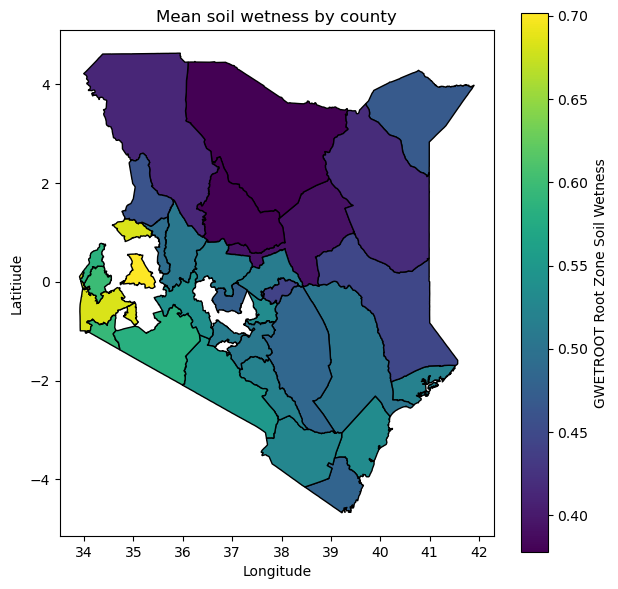

In [64]:

fig, ax = plt.subplots(figsize=(7,7))
gdf_final.plot('Mean soil wetness', legend=True, edgecolor='black',ax=ax, legend_kwds={'label':'GWETROOT Root Zone Soil Wetness'})
ax.set_title('Mean soil wetness by county')
ax.set_ylabel('Latitiude')
ax.set_xlabel('Longitude')
plt.show()